In [1]:
setwd('~/Downloads/proj/')

library(data.table)
library(edgeR)
library(EDASeq)
library(RUVSeq)
library(affycoretools)
library(ggplot2)
library(DESeq2)
library(pheatmap)
library(ggpubr)
library(fgsea)
library(clusterProfiler)
library(org.Hs.eg.db)
require(dplyr)
require(stringr)

# project directories, and libraries loaded and saving total number of patients

MM_cell_line = data.frame(fread("HMCL66_HTSeq_GENE_Counts_v3.txt"))
MM_patients = data.frame(fread("MMRF_CoMMpass_IA13a_E74GTF_HtSeq_Gene_Counts.txt"))

num_pat_tot = length(MM_patients[2,])
num_cell_line_tot = length(MM_cell_line[2,])

# checking total number of patients and cell lines and output head

head(MM_cell_line)
head(MM_patients)
print(num_pat_tot)
print(num_cell_line_tot)

Loading required package: limma
Loading required package: Biobase
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following object is masked from ‘package:limma’:

    plotMA

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, tab

Sample,GENE_NAME,ALMC1,ALMC2,AMO1,ANBL6,COLO677,Delta47,DP6,EJM,⋯,RPMI8226,SKMM1,SKMM2,U266,UTMC2,VP6,XG1,XG2,XG6,XG7
<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000000003,TSPAN6,2,0,100,2,0,0,2,88,⋯,2,0,0,0,0,0,0,0,2,114
ENSG00000000005,TNMD,1,0,0,0,1,0,0,0,⋯,0,1,0,0,0,0,0,0,0,0
ENSG00000000419,DPM1,3949,4134,4795,8278,2262,2587,3607,2450,⋯,2694,1247,3263,3044,3108,4538,7336,4430,9279,13828
ENSG00000000457,SCYL3,1597,1513,2412,1988,1530,926,1415,573,⋯,665,994,497,1611,1603,1375,1426,893,1540,1660
ENSG00000000460,C1orf112,3072,1488,2193,4091,3208,1170,3614,1618,⋯,1472,1517,1346,2068,3128,1850,2522,2320,793,689
ENSG00000000938,FGR,0,22,701,5,2,4,89,4,⋯,0,125,777,50,1890,2315,1514,5,3776,847


GENE_ID,MMRF_2801_1_BM,MMRF_2718_1_BM,MMRF_2815_1_BM,MMRF_1656_1_BM,MMRF_2461_1_BM,MMRF_2531_2_PB,MMRF_2057_1_BM,MMRF_1910_1_BM,MMRF_2089_2_BM,⋯,MMRF_2379_1_BM,MMRF_1474_1_BM,MMRF_1641_1_BM,MMRF_1978_2_BM,MMRF_2795_1_BM,MMRF_2316_1_BM,MMRF_2606_2_BM,MMRF_2440_1_BM,MMRF_2731_1_BM,MMRF_1355_1_BM
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000000003,17,999,85,9,801,20,12,16,4,⋯,2,186,102,347,128,17,11,3,18,6
ENSG00000000005,1,0,0,2,3,0,0,0,0,⋯,0,0,0,0,0,0,1,0,0,0
ENSG00000000419,1495,3271,2303,1234,1896,4400,2013,1745,1698,⋯,2459,1269,337,3347,1049,2545,1625,1253,1905,683
ENSG00000000457,231,809,203,1208,425,2793,710,922,853,⋯,734,771,327,392,90,406,857,548,808,393
ENSG00000000460,87,319,31,183,85,929,174,292,837,⋯,267,104,114,126,17,67,196,141,199,55
ENSG00000000938,318,105,119,190,2064,2952,12,351,498,⋯,46,14,303,2007,58,77,1037,11,174,22


[1] 893
[1] 68


In [2]:
# finding genes in common and creating character vector of Ensembl Gene IDs

ensembl_intersect = intersect(MM_cell_line$Sample, MM_patients$GENE_ID)

# assigning rownames as ensembl gene IDs so as to be able to parse by ensembl Gene IDs

rownames(MM_cell_line) = MM_cell_line$Sample
rownames(MM_patients) = MM_patients$GENE_ID

# removing gene ID and gene name columns 
# and saving them in a separate place 
# note only those available in MM_cell_line
# also filtering out genes in common
# and fusing them into a single dataframe
# and filtering for only newly diagnosed patients
# to be kept in a separate data frame

ensembl_ids = MM_cell_line[,1]
MM_cell_line = MM_cell_line[, -1]
gene_names = MM_cell_line[,1]
gene_info = cbind(ensembl_ids, gene_names)

MM_cell_line = MM_cell_line[,-1]
MM_cell_line = MM_cell_line[ensembl_intersect, ]
MM_patients = MM_patients[ensembl_intersect, -1]

MM_patient_ids = data.frame(colnames(MM_patients))
MM_patients_new = filter(MM_patient_ids, str_extract(MM_patient_ids[,1], "_[0-9]_") == "_1_")
keepc = colnames(MM_patients) %in% MM_patients_new[,1]
MM_patients_nd = MM_patients[,keepc]

MM_combined = cbind(MM_cell_line, MM_patients)
MM_combined_nd = cbind(MM_cell_line, MM_patients_nd)

# checking output head to confirm removal

head(MM_cell_line)
head(MM_patients)
head(MM_combined)
head(MM_combined_nd)
head(gene_info)

# saving number of newly diagnosed patients and printing out percentage

num_new_pat = length(MM_patients_nd[2,])
print(num_new_pat)
print((num_new_pat/num_pat_tot)*100)

,ALMC1,ALMC2,AMO1,ANBL6,COLO677,Delta47,DP6,EJM,FLAM76,FR4,⋯,RPMI8226,SKMM1,SKMM2,U266,UTMC2,VP6,XG1,XG2,XG6,XG7
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000000003,2,0,100,2,0,0,2,88,4,0,⋯,2,0,0,0,0,0,0,0,2,114
ENSG00000000005,1,0,0,0,1,0,0,0,0,0,⋯,0,1,0,0,0,0,0,0,0,0
ENSG00000000419,3949,4134,4795,8278,2262,2587,3607,2450,1388,3308,⋯,2694,1247,3263,3044,3108,4538,7336,4430,9279,13828
ENSG00000000457,1597,1513,2412,1988,1530,926,1415,573,1013,1232,⋯,665,994,497,1611,1603,1375,1426,893,1540,1660
ENSG00000000460,3072,1488,2193,4091,3208,1170,3614,1618,1507,1491,⋯,1472,1517,1346,2068,3128,1850,2522,2320,793,689
ENSG00000000938,0,22,701,5,2,4,89,4,2,2271,⋯,0,125,777,50,1890,2315,1514,5,3776,847


,MMRF_2801_1_BM,MMRF_2718_1_BM,MMRF_2815_1_BM,MMRF_1656_1_BM,MMRF_2461_1_BM,MMRF_2531_2_PB,MMRF_2057_1_BM,MMRF_1910_1_BM,MMRF_2089_2_BM,MMRF_2341_1_BM,⋯,MMRF_2379_1_BM,MMRF_1474_1_BM,MMRF_1641_1_BM,MMRF_1978_2_BM,MMRF_2795_1_BM,MMRF_2316_1_BM,MMRF_2606_2_BM,MMRF_2440_1_BM,MMRF_2731_1_BM,MMRF_1355_1_BM
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000000003,17,999,85,9,801,20,12,16,4,43,⋯,2,186,102,347,128,17,11,3,18,6
ENSG00000000005,1,0,0,2,3,0,0,0,0,1,⋯,0,0,0,0,0,0,1,0,0,0
ENSG00000000419,1495,3271,2303,1234,1896,4400,2013,1745,1698,2403,⋯,2459,1269,337,3347,1049,2545,1625,1253,1905,683
ENSG00000000457,231,809,203,1208,425,2793,710,922,853,1203,⋯,734,771,327,392,90,406,857,548,808,393
ENSG00000000460,87,319,31,183,85,929,174,292,837,478,⋯,267,104,114,126,17,67,196,141,199,55
ENSG00000000938,318,105,119,190,2064,2952,12,351,498,555,⋯,46,14,303,2007,58,77,1037,11,174,22


,ALMC1,ALMC2,AMO1,ANBL6,COLO677,Delta47,DP6,EJM,FLAM76,FR4,⋯,MMRF_2379_1_BM,MMRF_1474_1_BM,MMRF_1641_1_BM,MMRF_1978_2_BM,MMRF_2795_1_BM,MMRF_2316_1_BM,MMRF_2606_2_BM,MMRF_2440_1_BM,MMRF_2731_1_BM,MMRF_1355_1_BM
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000000003,2,0,100,2,0,0,2,88,4,0,⋯,2,186,102,347,128,17,11,3,18,6
ENSG00000000005,1,0,0,0,1,0,0,0,0,0,⋯,0,0,0,0,0,0,1,0,0,0
ENSG00000000419,3949,4134,4795,8278,2262,2587,3607,2450,1388,3308,⋯,2459,1269,337,3347,1049,2545,1625,1253,1905,683
ENSG00000000457,1597,1513,2412,1988,1530,926,1415,573,1013,1232,⋯,734,771,327,392,90,406,857,548,808,393
ENSG00000000460,3072,1488,2193,4091,3208,1170,3614,1618,1507,1491,⋯,267,104,114,126,17,67,196,141,199,55
ENSG00000000938,0,22,701,5,2,4,89,4,2,2271,⋯,46,14,303,2007,58,77,1037,11,174,22


,ALMC1,ALMC2,AMO1,ANBL6,COLO677,Delta47,DP6,EJM,FLAM76,FR4,⋯,MMRF_1731_1_BM,MMRF_2799_1_BM,MMRF_2379_1_BM,MMRF_1474_1_BM,MMRF_1641_1_BM,MMRF_2795_1_BM,MMRF_2316_1_BM,MMRF_2440_1_BM,MMRF_2731_1_BM,MMRF_1355_1_BM
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000000003,2,0,100,2,0,0,2,88,4,0,⋯,1,49,2,186,102,128,17,3,18,6
ENSG00000000005,1,0,0,0,1,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000000419,3949,4134,4795,8278,2262,2587,3607,2450,1388,3308,⋯,1751,2537,2459,1269,337,1049,2545,1253,1905,683
ENSG00000000457,1597,1513,2412,1988,1530,926,1415,573,1013,1232,⋯,493,220,734,771,327,90,406,548,808,393
ENSG00000000460,3072,1488,2193,4091,3208,1170,3614,1618,1507,1491,⋯,104,50,267,104,114,17,67,141,199,55
ENSG00000000938,0,22,701,5,2,4,89,4,2,2271,⋯,3064,46,46,14,303,58,77,11,174,22


ensembl_ids,gene_names
ENSG00000000003,TSPAN6
ENSG00000000005,TNMD
ENSG00000000419,DPM1
ENSG00000000457,SCYL3
ENSG00000000460,C1orf112
ENSG00000000938,FGR


[1] 779
[1] 87.23404


In [3]:
# transforming counts of cell_line, patients, and combined 
# to account for sequencing depth
# and creating boolean vector of those genes that
# holds TRUE for genes that account for greater than a millionth
# of total mapped reads in 2 or more samples
# then filtering MM_combined based on this vector
# aka filtering out low count genes
# and repeating for newly diagnosed only patients

MM_combined_cpm = cpm(MM_combined)
keep = rowSums(MM_combined_cpm > 1) > 2
MM_combined.filtered = MM_combined[keep, ]
MM_patients = MM_patients[keep, ]
MM_cell_line = MM_cell_line[keep, ]

MM_combined_nd_cpm = cpm(MM_combined_nd)
keep_nd = rowSums(MM_combined_nd_cpm > 1) > 2
MM_combined_nd.filtered = MM_combined_nd[keep_nd, ]
MM_patients_nd = MM_patients_nd[keep_nd, ]
MM_cell_line_nd = MM_cell_line[keep_nd, ]

# checking output head and number of low count genes remaining after filtering

head(keep)
head(MM_combined.filtered)
sum(keep)
sum(keep_nd)

ENSG00000000003 ENSG00000000005 ENSG00000000419 ENSG00000000457 ENSG00000000460 
           TRUE           FALSE            TRUE            TRUE            TRUE 
ENSG00000000938 
           TRUE

,ALMC1,ALMC2,AMO1,ANBL6,COLO677,Delta47,DP6,EJM,FLAM76,FR4,⋯,MMRF_2379_1_BM,MMRF_1474_1_BM,MMRF_1641_1_BM,MMRF_1978_2_BM,MMRF_2795_1_BM,MMRF_2316_1_BM,MMRF_2606_2_BM,MMRF_2440_1_BM,MMRF_2731_1_BM,MMRF_1355_1_BM
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000000003,2,0,100,2,0,0,2,88,4,0,⋯,2,186,102,347,128,17,11,3,18,6
ENSG00000000419,3949,4134,4795,8278,2262,2587,3607,2450,1388,3308,⋯,2459,1269,337,3347,1049,2545,1625,1253,1905,683
ENSG00000000457,1597,1513,2412,1988,1530,926,1415,573,1013,1232,⋯,734,771,327,392,90,406,857,548,808,393
ENSG00000000460,3072,1488,2193,4091,3208,1170,3614,1618,1507,1491,⋯,267,104,114,126,17,67,196,141,199,55
ENSG00000000938,0,22,701,5,2,4,89,4,2,2271,⋯,46,14,303,2007,58,77,1037,11,174,22
ENSG00000000971,11,207,24,21,18,8,685,12,28,2,⋯,13,5,28,118,30,18,1865,1680,56,10


[1] 22677

[1] 22459

In [4]:
# normalizing combined data frames with vst

norm_combined = vst(as.matrix(MM_combined.filtered))
norm_combined_nd = vst(as.matrix(MM_combined_nd.filtered))

# checking output head

head(norm_combined)
head(norm_combined_nd)

,ALMC1,ALMC2,AMO1,ANBL6,COLO677,Delta47,DP6,EJM,FLAM76,FR4,⋯,MMRF_2379_1_BM,MMRF_1474_1_BM,MMRF_1641_1_BM,MMRF_1978_2_BM,MMRF_2795_1_BM,MMRF_2316_1_BM,MMRF_2606_2_BM,MMRF_2440_1_BM,MMRF_2731_1_BM,MMRF_1355_1_BM
ENSG00000000003,4.631856,4.277689,6.557266,4.591941,4.277689,4.277689,4.633535,6.757867,4.854794,4.277689,⋯,4.724323,7.872087,7.279442,8.892504,8.268661,5.786579,5.238299,4.906192,5.573125,5.539938
ENSG00000000419,11.203503,11.074854,11.494757,11.915436,10.309063,10.999754,11.088513,11.014313,10.141935,11.745230,⋯,11.193842,10.433799,8.751681,12.055311,11.140925,11.779415,10.405654,10.644307,10.820096,10.844967
ENSG00000000457,9.931440,9.668281,10.522303,9.902041,9.765565,9.564948,9.777196,9.002211,9.705423,10.347211,⋯,9.503770,9.740347,8.712015,9.055347,7.830135,9.211329,9.518367,9.494629,9.623449,10.069578
ENSG00000000460,10.847890,9.645371,10.388723,10.913249,10.800240,9.887231,11.091261,10.429430,10.256753,10.615107,⋯,8.168128,7.194023,7.405635,7.612022,6.115524,6.992802,7.613518,7.733282,7.793913,7.505658
ENSG00000000938,4.277689,5.352556,8.827179,4.773110,4.618533,4.851261,6.447215,4.869862,4.687115,11.209973,⋯,6.266877,5.502307,8.612095,11.326184,7.314219,7.142771,9.780425,5.457562,7.633019,6.535104
ENSG00000000971,5.099227,7.152011,5.479271,5.277847,5.282185,5.083673,8.794912,5.289701,5.750034,4.744915,⋯,5.392960,5.023380,6.038515,7.534880,6.621261,5.826595,10.599142,11.058560,6.433822,5.876621


,ALMC1,ALMC2,AMO1,ANBL6,COLO677,Delta47,DP6,EJM,FLAM76,FR4,⋯,MMRF_1731_1_BM,MMRF_2799_1_BM,MMRF_2379_1_BM,MMRF_1474_1_BM,MMRF_1641_1_BM,MMRF_2795_1_BM,MMRF_2316_1_BM,MMRF_2440_1_BM,MMRF_2731_1_BM,MMRF_1355_1_BM
ENSG00000000003,5.121115,4.830701,6.753159,5.087762,4.830701,4.830701,5.122115,6.930293,5.303622,4.830701,⋯,5.131689,6.907446,5.196712,7.948939,7.400009,8.320791,6.082664,5.345835,5.900425,5.872658
ENSG00000000419,11.192958,11.058860,11.481792,11.894072,10.306507,10.979705,11.075250,11.003090,10.138017,11.723434,⋯,11.124923,11.843401,11.180281,10.426509,8.784326,11.123679,11.761265,10.632905,10.805345,10.830429
ENSG00000000457,9.936576,9.672406,10.518177,9.901600,9.772317,9.566903,9.781765,9.028327,9.709607,10.338227,⋯,9.384906,8.525344,9.514931,9.744664,8.746203,7.907656,9.229529,9.503027,9.627453,10.065296
ENSG00000000460,10.840491,9.650001,10.386322,10.898915,10.791701,9.882322,11.077974,10.424602,10.251060,10.602664,⋯,7.505744,6.925478,8.229035,7.322156,7.515750,6.363182,7.140238,7.818035,7.873429,7.606155
ENSG00000000938,4.830701,5.715836,8.861104,5.236351,5.110011,5.299783,6.654161,5.316598,5.165852,11.191736,⋯,11.916476,6.851781,6.496629,5.841891,8.650335,7.430139,7.276126,5.803804,7.723670,6.729497
ENSG00000000971,5.506729,7.282633,5.824017,5.653577,5.658535,5.491225,8.827028,5.664625,6.050852,5.213020,⋯,11.664665,6.426298,5.750688,5.442846,6.297891,6.805684,6.116758,11.042982,6.640096,6.157982


In [5]:
# separating out patient and cell line columns from norm_combined and norm_combined_nd

norm_pat = norm_combined[,colnames(MM_patients)]
norm_cell = norm_combined[,colnames(MM_cell_line)]
norm_pat_nd = norm_combined_nd[,colnames(MM_patients_nd)]
norm_cell_nd = norm_combined_nd[,colnames(MM_cell_line_nd)]

# checking output head

head(norm_pat)
head(norm_cell)
head(norm_pat_nd)
head(norm_cell_nd)

,MMRF_2801_1_BM,MMRF_2718_1_BM,MMRF_2815_1_BM,MMRF_1656_1_BM,MMRF_2461_1_BM,MMRF_2531_2_PB,MMRF_2057_1_BM,MMRF_1910_1_BM,MMRF_2089_2_BM,MMRF_2341_1_BM,⋯,MMRF_2379_1_BM,MMRF_1474_1_BM,MMRF_1641_1_BM,MMRF_1978_2_BM,MMRF_2795_1_BM,MMRF_2316_1_BM,MMRF_2606_2_BM,MMRF_2440_1_BM,MMRF_2731_1_BM,MMRF_1355_1_BM
ENSG00000000003,5.763143,9.537185,7.395753,5.308595,9.830803,5.274120,5.550078,5.500219,4.872554,5.880590,⋯,4.724323,7.872087,7.279442,8.892504,8.268661,5.786579,5.238299,4.906192,5.573125,5.539938
ENSG00000000419,10.974725,11.195989,11.818120,10.507028,11.038501,11.074396,11.418836,10.688833,10.510092,10.569849,⋯,11.193842,10.433799,8.751681,12.055311,11.140925,11.779415,10.405654,10.644307,10.820096,10.844967
ENSG00000000457,8.420720,9.249930,8.461872,10.477123,8.968302,10.433395,9.951931,9.797906,9.553685,9.607254,⋯,9.503770,9.740347,8.712015,9.055347,7.830135,9.211329,9.518367,9.494629,9.623449,10.069578
ENSG00000000460,7.240012,8.035522,6.362907,7.950493,7.004830,8.922297,8.080643,8.263642,9.527754,8.376546,⋯,8.168128,7.194023,7.405635,7.612022,6.115524,6.992802,7.613518,7.733282,7.793913,7.505658
ENSG00000000938,8.838641,6.773748,7.792299,7.996890,11.158836,10.511120,5.550078,8.499929,8.827716,8.569701,⋯,6.266877,5.502307,8.612095,11.326184,7.314219,7.142771,9.780425,5.457562,7.633019,6.535104
ENSG00000000971,8.954700,9.660588,9.272141,7.626551,8.452307,12.823135,5.732564,8.006766,9.272567,5.736415,⋯,5.392960,5.023380,6.038515,7.534880,6.621261,5.826595,10.599142,11.058560,6.433822,5.876621


,ALMC1,ALMC2,AMO1,ANBL6,COLO677,Delta47,DP6,EJM,FLAM76,FR4,⋯,RPMI8226,SKMM1,SKMM2,U266,UTMC2,VP6,XG1,XG2,XG6,XG7
ENSG00000000003,4.631856,4.277689,6.557266,4.591941,4.277689,4.277689,4.633535,6.757867,4.854794,4.277689,⋯,4.707500,4.277689,4.277689,4.277689,4.277689,4.277689,4.277689,4.277689,4.628974,6.456153
ENSG00000000419,11.203503,11.074854,11.494757,11.915436,10.309063,10.999754,11.088513,11.014313,10.141935,11.745230,⋯,11.213561,10.093941,11.352302,10.930239,10.590877,11.140197,11.955852,11.043716,12.398838,12.666907
ENSG00000000457,9.931440,9.668281,10.522303,9.902041,9.765565,9.564948,9.777196,9.002211,9.705423,10.347211,⋯,9.264065,9.779521,8.749033,10.037164,9.668741,9.472541,9.649261,8.832004,9.858348,9.669506
ENSG00000000460,10.847890,9.645371,10.388723,10.913249,10.800240,9.887231,11.091261,10.429430,10.256753,10.615107,⋯,10.360803,10.367704,10.104580,10.385818,10.599902,9.880745,10.441824,10.134136,8.954919,8.491219
ENSG00000000938,4.277689,5.352556,8.827179,4.773110,4.618533,4.851261,6.447215,4.869862,4.687115,11.209973,⋯,4.277689,7.148103,9.347799,6.008208,9.896101,10.192478,9.731689,4.776205,11.116661,8.761160
ENSG00000000971,5.099227,7.152011,5.479271,5.277847,5.282185,5.083673,8.794912,5.289701,5.750034,4.744915,⋯,7.084740,5.339650,6.334592,4.643934,6.922797,5.655105,6.618223,8.390881,7.857338,7.031385


,MMRF_2801_1_BM,MMRF_2718_1_BM,MMRF_2815_1_BM,MMRF_1656_1_BM,MMRF_2461_1_BM,MMRF_2057_1_BM,MMRF_1910_1_BM,MMRF_2341_1_BM,MMRF_2501_1_BM,MMRF_1383_1_BM,⋯,MMRF_1731_1_BM,MMRF_2799_1_BM,MMRF_2379_1_BM,MMRF_1474_1_BM,MMRF_1641_1_BM,MMRF_2795_1_BM,MMRF_2316_1_BM,MMRF_2440_1_BM,MMRF_2731_1_BM,MMRF_1355_1_BM
ENSG00000000003,6.060798,9.545865,7.504912,5.678664,9.831334,5.882917,5.839145,6.162487,9.012450,10.080853,⋯,5.131689,6.907446,5.196712,7.948939,7.400009,8.320791,6.082664,5.345835,5.900425,5.872658
ENSG00000000419,10.957643,11.180638,11.796341,10.495380,11.022594,11.404325,10.675590,10.560857,10.541196,10.548945,⋯,11.124923,11.843401,11.180281,10.426509,8.784326,11.123679,11.761265,10.632905,10.805345,10.830429
ENSG00000000457,8.464263,9.266066,8.504619,10.465857,8.991437,9.954385,9.798282,9.614478,9.901645,9.854608,⋯,9.384906,8.525344,9.514931,9.744664,8.746203,7.907656,9.229529,9.503027,9.627453,10.065296
ENSG00000000460,7.361361,8.102342,6.578214,8.019636,7.149116,8.146953,8.315703,8.425506,7.797638,7.725440,⋯,7.505744,6.925478,8.229035,7.322156,7.515750,6.363182,7.140238,7.818035,7.873429,7.606155
ENSG00000000938,8.864747,6.942817,7.872284,8.063233,11.141904,5.882917,8.540640,8.609911,6.225164,6.277881,⋯,11.916476,6.851781,6.496629,5.841891,8.650335,7.430139,7.276126,5.803804,7.723670,6.729497
ENSG00000000971,8.976686,9.666459,9.285435,7.717287,8.495919,6.037327,8.073008,6.039664,6.582150,6.067497,⋯,11.664665,6.426298,5.750688,5.442846,6.297891,6.805684,6.116758,11.042982,6.640096,6.157982


,ALMC1,ALMC2,AMO1,ANBL6,COLO677,Delta47,DP6,EJM,FLAM76,FR4,⋯,RPMI8226,SKMM1,SKMM2,U266,UTMC2,VP6,XG1,XG2,XG6,XG7
ENSG00000000003,5.121115,4.830701,6.753159,5.087762,4.830701,4.830701,5.122115,6.930293,5.303622,4.830701,⋯,5.183315,4.830701,4.830701,4.830701,4.830701,4.830701,4.830701,4.830701,5.118442,6.661173
ENSG00000000419,11.192958,11.058860,11.481792,11.894072,10.306507,10.979705,11.075250,11.003090,10.138017,11.723434,⋯,11.203237,10.090880,11.337907,10.916534,10.580120,11.126976,11.934854,11.032084,12.378849,12.643881
ENSG00000000457,9.936576,9.672406,10.518177,9.901600,9.772317,9.566903,9.781765,9.028327,9.709607,10.338227,⋯,9.284631,9.782236,8.783722,10.035066,9.673136,9.484374,9.654509,8.863879,9.861965,9.674925
ENSG00000000460,10.840491,9.650001,10.386322,10.898915,10.791701,9.882322,11.077974,10.424602,10.251060,10.602664,⋯,10.359418,10.360492,10.104075,10.378362,10.589037,9.883744,10.433379,10.133464,8.981951,8.534477
ENSG00000000938,4.830701,5.715836,8.861104,5.236351,5.110011,5.299783,6.654161,5.316598,5.165852,11.191736,⋯,4.830701,7.279769,9.363245,6.271504,9.895878,10.190136,9.735164,5.239458,11.103832,8.793222
ENSG00000000971,5.506729,7.282633,5.824017,5.653577,5.658535,5.491225,8.827028,5.664625,6.050852,5.213020,⋯,7.226316,5.705353,6.555933,5.130448,7.075538,5.971329,6.803862,8.441138,7.936526,7.174217


In [6]:
# utilizing IQR to get vector of top 5000 and top 10000 genes
# for all and newly diagnosed separately

keepi = apply(norm_pat, 1, IQR)
keepis = sort(keepi, decreasing = TRUE)
keepi5000 = keepi %in% keepis[1:5000]
keepi10000 = keepi %in% keepis[1:10000]

keepi_nd = apply(norm_pat_nd, 1, IQR)
keepis_nd = sort(keepi_nd, decreasing = TRUE)
keepi5000_nd = keepi_nd %in% keepis_nd[1:5000]
keepi10000_nd = keepi_nd %in% keepis_nd[1:10000]

In [7]:
# making function for doing correlation analysis and generating violin plots

makeplots = function(corset, pnames, clnames, titl) {
    
    MM.cor.v = cor(corset, method = "s")

    #clnames = colnames(MM_cell_line)
    tumor_cell_all = data.frame()

    for(patients in pnames){
        cell_line_tumor_cor = MM.cor.v[patients, clnames]
        cell_line_tumor_cor = data.frame(patient = patients, 
                                         sample = names(cell_line_tumor_cor), cor = cell_line_tumor_cor)
        tumor_cell_all = rbind(tumor_cell_all, cell_line_tumor_cor)
    }

    cell_line_order <- aggregate(cor ~ sample, tumor_cell_all, median)
    cell_line_ordered <- cell_line_order$sample[order(cell_line_order$cor, decreasing=T)]
    tumor_cell_all$sample = factor(tumor_cell_all$sample, levels = cell_line_ordered)

      p <- ggplot(tumor_cell_all, aes(sample, cor))
      print(p + geom_violin()  +  ylab("correlation") + geom_boxplot(width=0.2) + ylab('R') +
              xlab("") + labs(title = titl) +
              stat_summary(geom = "crossbar", width=0.2, fatten=2, color="red", 
                           fun.data = function(x){ return(c(y=median(x), ymin=median(x), ymax=median(x))) }) +  
            theme(panel.background = element_rect(color = 'white'), 
                  axis.text.x = element_text(angle = 70, hjust = 1, size=8))# + stat_compare_means()
      )
   # return(cell_line_order)
}

,ALMC1,ALMC2,AMO1,ANBL6,COLO677,Delta47,DP6,EJM,FLAM76,FR4,⋯,MMRF_1731_1_BM,MMRF_2799_1_BM,MMRF_2379_1_BM,MMRF_1474_1_BM,MMRF_1641_1_BM,MMRF_2795_1_BM,MMRF_2316_1_BM,MMRF_2440_1_BM,MMRF_2731_1_BM,MMRF_1355_1_BM
ENSG00000000003,4.631856,4.277689,6.557266,4.591941,4.277689,4.277689,4.633535,6.757867,4.854794,4.277689,⋯,4.645601,6.735236,4.724323,7.872087,7.279442,8.268661,5.786579,4.906192,5.573125,5.539938
ENSG00000000460,10.847890,9.645371,10.388723,10.913249,10.800240,9.887231,11.091261,10.429430,10.256753,10.615107,⋯,7.396229,6.755457,8.168128,7.194023,7.405635,6.115524,6.992802,7.733282,7.793913,7.505658
ENSG00000000938,4.277689,5.352556,8.827179,4.773110,4.618533,4.851261,6.447215,4.869862,4.687115,11.209973,⋯,11.938327,6.672686,6.266877,5.502307,8.612095,7.314219,7.142771,5.457562,7.633019,6.535104
ENSG00000000971,5.099227,7.152011,5.479271,5.277847,5.282185,5.083673,8.794912,5.289701,5.750034,4.744915,⋯,11.685182,6.187998,5.392960,5.023380,6.038515,6.621261,5.826595,11.058560,6.433822,5.876621
ENSG00000001561,11.299764,11.117408,10.699169,9.186855,8.748253,10.206546,11.290563,9.731783,10.226765,9.290325,⋯,9.314724,9.272840,12.204722,9.798182,7.611145,8.829046,10.531100,10.757729,10.380698,10.913626
ENSG00000002586,9.380980,6.053948,7.358972,5.070450,10.986954,4.565888,6.487835,4.791415,11.911219,4.744915,⋯,10.704127,10.891096,6.041618,6.413483,7.000104,8.572020,14.222973,6.001932,6.240530,8.344365


,ALMC1,ALMC2,AMO1,ANBL6,COLO677,Delta47,DP6,EJM,FLAM76,FR4,⋯,MMRF_1731_1_BM,MMRF_2799_1_BM,MMRF_2379_1_BM,MMRF_1474_1_BM,MMRF_1641_1_BM,MMRF_2795_1_BM,MMRF_2316_1_BM,MMRF_2440_1_BM,MMRF_2731_1_BM,MMRF_1355_1_BM
ENSG00000000003,5.121115,4.830701,6.753159,5.087762,4.830701,4.830701,5.122115,6.930293,5.303622,4.830701,⋯,5.131689,6.907446,5.196712,7.948939,7.400009,8.320791,6.082664,5.345835,5.900425,5.872658
ENSG00000000460,10.840491,9.650001,10.386322,10.898915,10.791701,9.882322,11.077974,10.424602,10.251060,10.602664,⋯,7.505744,6.925478,8.229035,7.322156,7.515750,6.363182,7.140238,7.818035,7.873429,7.606155
ENSG00000000938,4.830701,5.715836,8.861104,5.236351,5.110011,5.299783,6.654161,5.316598,5.165852,11.191736,⋯,11.916476,6.851781,6.496629,5.841891,8.650335,7.430139,7.276126,5.803804,7.723670,6.729497
ENSG00000000971,5.506729,7.282633,5.824017,5.653577,5.658535,5.491225,8.827028,5.664625,6.050852,5.213020,⋯,11.664665,6.426298,5.750688,5.442846,6.297891,6.805684,6.116758,11.042982,6.640096,6.157982
ENSG00000001036,7.150127,10.205189,11.706649,11.119109,11.964247,10.869906,12.264824,11.022433,10.523320,11.761523,⋯,11.366889,11.390647,12.240746,9.971044,9.416014,11.431560,12.629040,10.806432,9.426269,10.866817
ENSG00000001561,11.288489,11.101051,10.692980,9.203449,8.783962,10.196110,11.275689,9.738624,10.221523,9.302731,⋯,9.327332,9.286848,12.185353,9.801319,7.705559,8.856684,10.523423,10.745066,10.371202,10.898409


[1] 4638

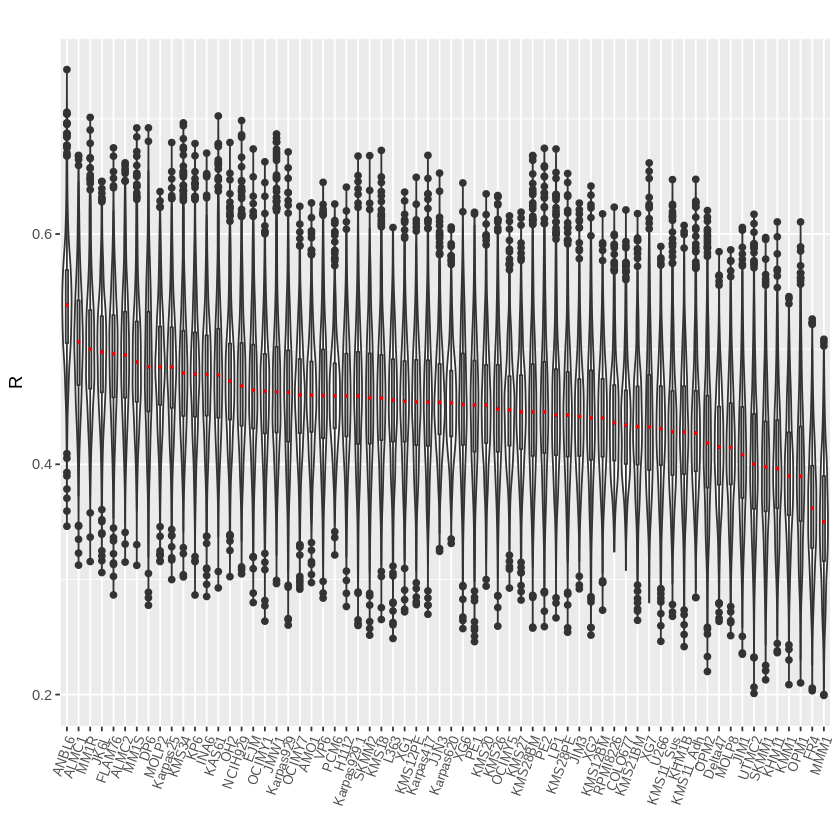

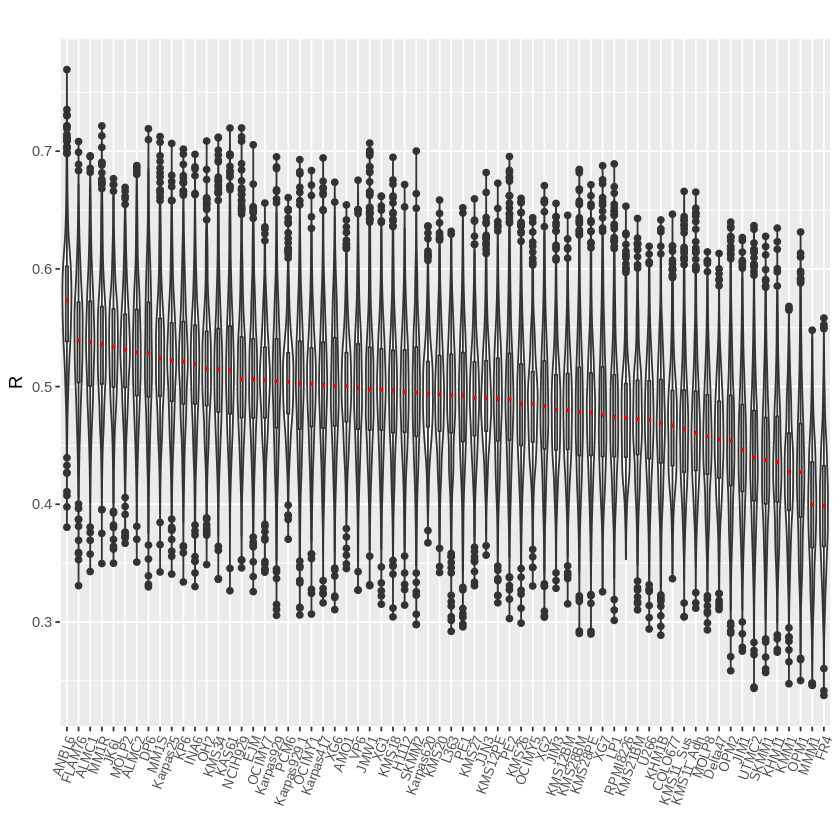

In [8]:
# subsetting top 5000 / 10000 genes

norm_combined_ndo_5 = norm_combined[keepi5000,]
tv = norm_combined_ndo_5[,colnames(norm_cell_nd)]
tv2 = norm_combined_ndo_5[,colnames(norm_pat_nd)]
norm_combined_ndo_5 = cbind(tv, tv2)

norm_combined_ndo_10 = norm_combined[keepi10000,]
tv = norm_combined_ndo_10[,colnames(norm_cell_nd)]
tv2 = norm_combined_ndo_10[,colnames(norm_pat_nd)]
norm_combined_ndo_10 = cbind(tv, tv2)

norm_combined_nd_5 = norm_combined_nd[keepi5000_nd,]
norm_combined_nd_10 = norm_combined_nd[keepi10000_nd,]

head(norm_combined_ndo_5)
head(norm_combined_nd_5)
sum(rownames(norm_combined_ndo_5) %in% rownames(norm_combined_nd_5))

# plots for main analysis using top 5000 / 10000 genes

MM.cor.keats_5000 = cor(norm_combined_ndo_5, method = "s")
MM.cor.keats_10000 = cor(norm_combined_ndo_10, method = "s")
MM.cor.keats_nd_5000 = cor(norm_combined_nd_5, method = "s")
MM.cor.keats__nd_10000 = cor(norm_combined_nd_10, method = "s")

makeplots(norm_combined_ndo_5, colnames(MM_patients_nd), colnames(MM_cell_line), '')
makeplots(norm_combined_nd_5, colnames(MM_patients_nd), colnames(MM_cell_line), '')

In [9]:
MM.cor.keats_5000 = (MM.cor.keats_5000[,colnames(MM_cell_line)])
MM.cor.keats_5000 = (MM.cor.keats_5000[colnames(MM_patients_nd),])
MM.cor.keats_nd_5000 = (MM.cor.keats_nd_5000[,colnames(MM_cell_line)])
MM.cor.keats_nd_5000 = (MM.cor.keats_nd_5000[colnames(MM_patients_nd),])

,cor,type
,<dbl>,<chr>
ALMC1,0.5066608,Normalized with all patients
ALMC2,0.4967268,Normalized with all patients
AMO1,0.4595980,Normalized with all patients
ANBL6,0.5379676,Normalized with all patients
COLO677,0.4367230,Normalized with all patients
Delta47,0.4158869,Normalized with all patients


,cor,type
,<dbl>,<chr>
ALMC1,0.5369961,Normalized with only newly diagnosed patients
ALMC2,0.5300274,Normalized with only newly diagnosed patients
AMO1,0.5001054,Normalized with only newly diagnosed patients
ANBL6,0.5717817,Normalized with only newly diagnosed patients
COLO677,0.4689277,Normalized with only newly diagnosed patients
Delta47,0.4551389,Normalized with only newly diagnosed patients


,cor,type
,<dbl>,<chr>
ALMC1,0.5066608,Normalized with all patients
ALMC2,0.4967268,Normalized with all patients
AMO1,0.4595980,Normalized with all patients
ANBL6,0.5379676,Normalized with all patients
COLO677,0.4367230,Normalized with all patients
Delta47,0.4158869,Normalized with all patients


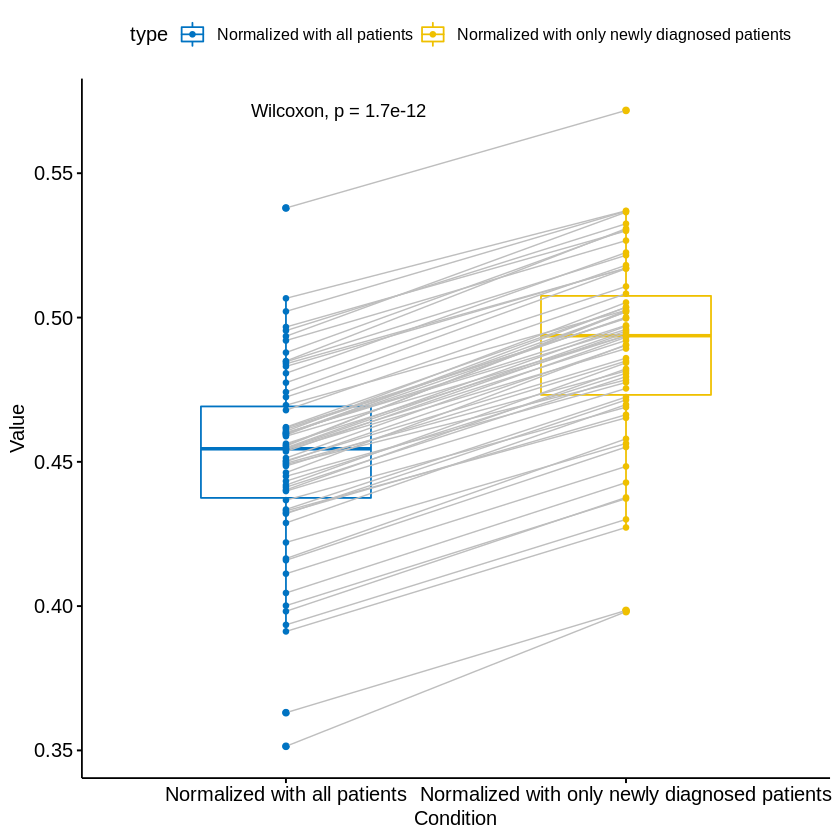

In [10]:
MM.cor.keats_5000_means = data.frame(colMeans(MM.cor.keats_5000))
MM.cor.keats_5000_means$type = 'Normalized with all patients'
colnames(MM.cor.keats_5000_means) = c('cor', 'type')

MM.cor.keats_nd_5000_means = data.frame(colMeans(MM.cor.keats_nd_5000))
MM.cor.keats_nd_5000_means$type = 'Normalized with only newly diagnosed patients'
colnames(MM.cor.keats_nd_5000_means) = c('cor', 'type')

head(MM.cor.keats_5000_means)
head(MM.cor.keats_nd_5000_means)

normchk_bound = rbind(MM.cor.keats_5000_means, MM.cor.keats_nd_5000_means)

head(normchk_bound)

ggpaired(normchk_bound, x = "type", y = "cor",
         color = "type", line.color = "gray", line.size = 0.4,
         palette = "jco")+
  stat_compare_means(paired = TRUE)

In [11]:
rank_gen = c(1:length(MM.cor.keats_5000_means[,1]))

head(MM.cor.keats_5000_means)

MM.cor.keats_5000_ranks = MM.cor.keats_5000_means[order(-MM.cor.keats_5000_means$cor),]

head(MM.cor.keats_5000_ranks)

MM.cor.keats_5000_ranks$rank = rank_gen

tail(MM.cor.keats_5000_ranks)

head(MM.cor.keats_nd_5000_means)

MM.cor.keats_nd_5000_ranks = MM.cor.keats_nd_5000_means[order(-MM.cor.keats_nd_5000_means$cor),]

MM.cor.keats_nd_5000_ranks$rank = rank_gen

tail(MM.cor.keats_nd_5000_ranks)
# cor_ccle = cor_ccle[order(cor_ccle$names),]
# MM.cor.keats_5000_means = as.data.frame(MM.cor.keats_5000_means)
# MM.cor.keats_5000_means$rank = rank_gen
# MM.cor.keats_5000_means$type = 'Top 5000 genes'
# MM.cor.keats_5000_means = MM.cor.keats_5000_means[-1]
# MM.cor.keats_10000_means = as.data.frame(MM.cor.keats_10000_means)
# MM.cor.keats_10000_means$rank = rank_gen
# MM.cor.keats_10000_means$type = 'Top 10000 genes'
# MM.cor.keats_10000_means = MM.cor.keats_10000_means[-1]
# head(MM.cor.keats_5000_means)

,cor,type
,<dbl>,<chr>
ALMC1,0.5066608,Normalized with all patients
ALMC2,0.4967268,Normalized with all patients
AMO1,0.4595980,Normalized with all patients
ANBL6,0.5379676,Normalized with all patients
COLO677,0.4367230,Normalized with all patients
Delta47,0.4158869,Normalized with all patients


,cor,type
,<dbl>,<chr>
ANBL6,0.5379676,Normalized with all patients
ALMC1,0.5066608,Normalized with all patients
MM1R,0.5021266,Normalized with all patients
ALMC2,0.4967268,Normalized with all patients
JK6L,0.4954662,Normalized with all patients
FLAM76,0.4935216,Normalized with all patients


,cor,type,rank
,<dbl>,<chr>,<int>
KHM11,0.4001656,Normalized with all patients,61
SKMM1,0.3982044,Normalized with all patients,62
OPM1,0.3935106,Normalized with all patients,63
KMM1,0.3912283,Normalized with all patients,64
FR4,0.3630693,Normalized with all patients,65
MMM1,0.3514224,Normalized with all patients,66


,cor,type
,<dbl>,<chr>
ALMC1,0.5369961,Normalized with only newly diagnosed patients
ALMC2,0.5300274,Normalized with only newly diagnosed patients
AMO1,0.5001054,Normalized with only newly diagnosed patients
ANBL6,0.5717817,Normalized with only newly diagnosed patients
COLO677,0.4689277,Normalized with only newly diagnosed patients
Delta47,0.4551389,Normalized with only newly diagnosed patients


,cor,type,rank
,<dbl>,<chr>,<int>
SKMM1,0.4376553,Normalized with only newly diagnosed patients,61
KHM11,0.4372499,Normalized with only newly diagnosed patients,62
OPM1,0.4300588,Normalized with only newly diagnosed patients,63
KMM1,0.4272517,Normalized with only newly diagnosed patients,64
FR4,0.3985122,Normalized with only newly diagnosed patients,65
MMM1,0.3980913,Normalized with only newly diagnosed patients,66


In [12]:
MM.cor.keats_5000_ranks = MM.cor.keats_5000_ranks[order(rownames(MM.cor.keats_5000_ranks)),]
# MM.cor.keats_nd_5000_ranks = MM.cor.keats_nd_5000_means[order(-MM.cor.keats_nd_5000_means$cor),]
head(MM.cor.keats_5000_ranks)

MM.cor.keats_nd_5000_ranks = MM.cor.keats_nd_5000_ranks[order(rownames(MM.cor.keats_nd_5000_ranks)),]

head(MM.cor.keats_nd_5000_ranks)

rank_base_bound = cbind(MM.cor.keats_nd_5000_ranks, MM.cor.keats_5000_ranks)

head(rank_base_bound)

,cor,type,rank
,<dbl>,<chr>,<int>
ALMC1,0.5066608,Normalized with all patients,2
ALMC2,0.4967268,Normalized with all patients,4
AMO1,0.4595980,Normalized with all patients,26
ANBL6,0.5379676,Normalized with all patients,1
COLO677,0.4367230,Normalized with all patients,50
Delta47,0.4158869,Normalized with all patients,58


,cor,type,rank
,<dbl>,<chr>,<int>
ALMC1,0.5369961,Normalized with only newly diagnosed patients,2
ALMC2,0.5300274,Normalized with only newly diagnosed patients,8
AMO1,0.5001054,Normalized with only newly diagnosed patients,25
ANBL6,0.5717817,Normalized with only newly diagnosed patients,1
COLO677,0.4689277,Normalized with only newly diagnosed patients,53
Delta47,0.4551389,Normalized with only newly diagnosed patients,58


,cor,type,rank,cor,type,rank
,<dbl>,<chr>,<int>,<dbl>,<chr>,<int>
ALMC1,0.5369961,Normalized with only newly diagnosed patients,2,0.5066608,Normalized with all patients,2
ALMC2,0.5300274,Normalized with only newly diagnosed patients,8,0.4967268,Normalized with all patients,4
AMO1,0.5001054,Normalized with only newly diagnosed patients,25,0.4595980,Normalized with all patients,26
ANBL6,0.5717817,Normalized with only newly diagnosed patients,1,0.5379676,Normalized with all patients,1
COLO677,0.4689277,Normalized with only newly diagnosed patients,53,0.4367230,Normalized with all patients,50
Delta47,0.4551389,Normalized with only newly diagnosed patients,58,0.4158869,Normalized with all patients,58


In [13]:
head(rank_base_bound)

,cor,type,rank,cor,type,rank
,<dbl>,<chr>,<int>,<dbl>,<chr>,<int>
ALMC1,0.5369961,Normalized with only newly diagnosed patients,2,0.5066608,Normalized with all patients,2
ALMC2,0.5300274,Normalized with only newly diagnosed patients,8,0.4967268,Normalized with all patients,4
AMO1,0.5001054,Normalized with only newly diagnosed patients,25,0.4595980,Normalized with all patients,26
ANBL6,0.5717817,Normalized with only newly diagnosed patients,1,0.5379676,Normalized with all patients,1
COLO677,0.4689277,Normalized with only newly diagnosed patients,53,0.4367230,Normalized with all patients,50
Delta47,0.4551389,Normalized with only newly diagnosed patients,58,0.4158869,Normalized with all patients,58


,newly_diagnosed_only,all_patients
,<int>,<int>
ANBL6,1,1
ALMC1,2,2
MM1R,3,3
FLAM76,4,6
JK6L,5,5
MOLP2,6,9


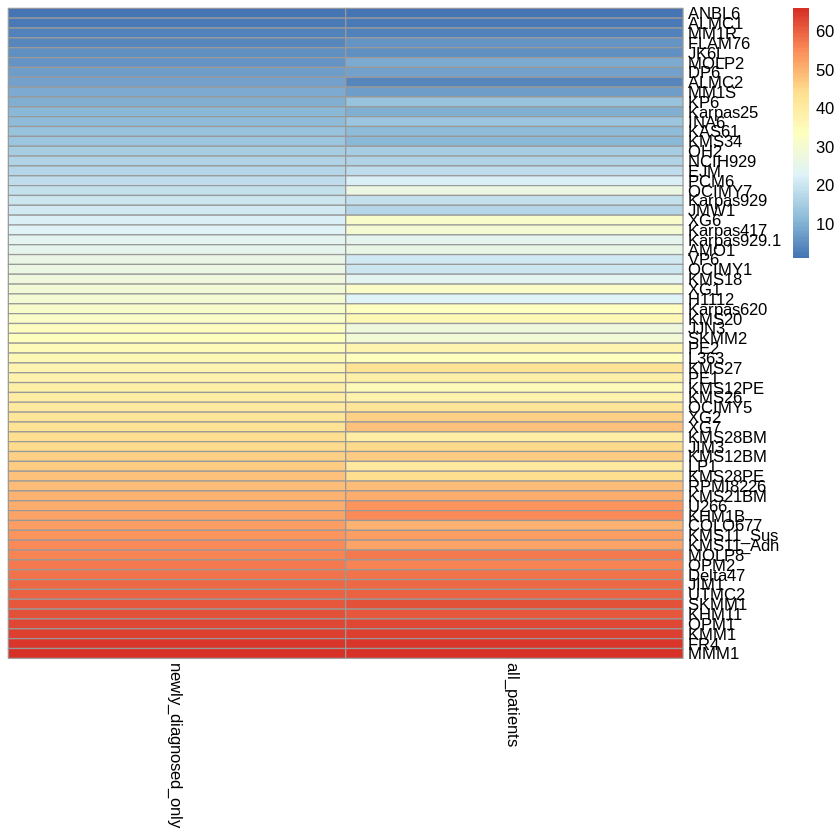

In [14]:
rank_base_bound = rank_base_bound[-1]
rank_base_bound = rank_base_bound[-1]
rank_base_bound = rank_base_bound[-2]
rank_base_bound = rank_base_bound[-2]
colnames(rank_base_bound) = c('newly_diagnosed_only', 'all_patients')
rank_base_bound = rank_base_bound[order(rank_base_bound$newly_diagnosed_only),]
head(rank_base_bound)

pheatmap(rank_base_bound, cluster_rows = FALSE, cluster_cols = FALSE)